In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn import metrics

In [2]:
pd.set_option('future.no_silent_downcasting', True)
PALETTE = sns.color_palette('flare_r', as_cmap=True)
alt.renderers.enable('browser')

RendererRegistry.enable('browser')

# Section I: Clusering Evaluation

In [3]:
def label_clusters(row):
    unique_values = row.unique()
    letter_digit = {}
    for number, value in enumerate(unique_values):
        letter_digit[value] = number
    row = row.replace(letter_digit)
    return row

def calculate_metric(row, metric, true_labels):
    return(metric(row, true_labels))

# Standard: "DATASET_{NUMBER OF CLIENTS}_{SPLIT TYPE}"
# 'NB' - Nonoverlaping Balanced
# 'NI' - Nonoverlaping Imbalanced
# 'OB' - Overlaping Balanced
# 'OI' - Overlaping Imbalanced
datasets = ['MNIST', 'FMNIST', 'CIFAR10', 'PATHMNIST', 'BLOODMNIST']
no_of_clients = ['15', '30']
split_types = ['nonoverlaping', 'overlaping']
split_balance = ['balanced', 'imbalanced']
split_type_balance = ['nonoverlaping_balanced', 'nonoverlaping_imbalanced', 'overlaping_balanced', 'overlaping_imbalanced']
scenarios = [
    f"{dataset}_{clients}_{split}_{balance}"
    for dataset in datasets
    for clients in no_of_clients
    for split in split_types
    for balance in split_balance
]
algos = ['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN']

clustering_info_stack = ['RAND', 'AMI', 'COM']
clustering_avg_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=clustering_info_stack)
    # RAND: Rand Score
    # AMI: Adjusted Mutual Information Score
    # COM: Cluster Completeness
    for scenario in scenarios
}

TRUE_LABELS = {
    'nonoverlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
}

In [4]:
for dataset in datasets:
    for no_clients in no_of_clients:
        for split in split_types:
            for balance in split_balance:
            
                # I. Clustering Correctness
                ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                BASELINE_ATT = pd.read_csv(os.path.join(ROOT, f'baseline_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                SATTLER_ATT = pd.read_csv(os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, f'briggs_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                KMEANS_ATT = pd.read_csv(os.path.join(ROOT, f'kmeans_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, f'affinity_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, f'meanshift_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, f'HDBSCAN_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                
                true_labels = TRUE_LABELS[f'{split}_{balance}_{no_clients}']
                
                BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
                SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
                BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
                KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
                AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
                MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
                HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
                
                RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                
                MIS_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                MIS_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                
                COM_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                COM_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                
                key = f'{dataset}_{no_clients}_{split}_{balance}'
                clustering_avg_per_scenario[key]['RAND'] = RAND_SCORES.mean()
                clustering_avg_per_scenario[key]['AMI'] = MIS_SCORES.mean()
                clustering_avg_per_scenario[key]['COM'] = COM_SCORES.mean()
                if not os.path.exists(os.path.join(os.getcwd(), 'tables', 'clustering_performance')):
                    os.makedirs(os.path.join(os.getcwd(), 'tables', 'clustering_performance'))
                
                with open(os.path.join(os.getcwd(), 'tables', 'clustering_performance', f"{key}.tex"), 'w+') as file:
                    file.write(clustering_avg_per_scenario[key].to_latex(float_format="%.2f"))

# Section II: Performance Evaluation

In [5]:
# Standard: "DATASET_{NUMBER OF CLIENTS}_{SPLIT TYPE}"
# 'NB' - Nonoverlaping Balanced
# 'NI' - Nonoverlaping Imbalanced
# 'OB' - Overlaping Balanced
# 'OI' -ssa Overlaping Imbalanced
datasets = ['MNIST', 'FMNIST', 'CIFAR10', 'PATHMNIST', 'BLOODMNIST']
no_of_clients = ['15', '30']
split_types = ['nonoverlaping', 'overlaping']
split_balance = ['balanced', 'imbalanced']
scenarios = [
    f"{dataset}_{clients}_{split}_{balance}"
    for dataset in datasets
    for clients in no_of_clients
    for split in split_types
    for balance in split_balance
]
algos = ['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB']

learning_info_stack = ['PA', 'PF1', 'GA', 'GF1', 'DIST']
learning_avg_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=learning_info_stack)
    # PA: Personalization Accuracy
    # PF1: Personalization F1score
    # GA: Generalization Accuracy
    # GF1: Generalization F1Score
    # DIST: Adjusted Distance (1 - |PA - GA|)
    for scenario in scenarios
}

full_info_stack = ['mean', 'std', 'min', 'max', '25%', '50%', '75%']
full_acc_info_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=full_info_stack)
    for scenario in scenarios
}

full_f1_info_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=full_info_stack)
    for scenario in scenarios
}

In [6]:
for dataset in datasets:
    for no_clients in no_of_clients:
        for split in split_types:
            for balance in split_balance:
                
                # Loading and calculating performance scores
                ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                BASELINE = os.path.join(ROOT, f'baseline_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                SATTLER = os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                BRIGGS = os.path.join(ROOT, f'briggs_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                KMEANS = os.path.join(ROOT, f'kmeans_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                AFFINITY = os.path.join(ROOT, f'affinity_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                MEAN_SHIFT = os.path.join(ROOT, f'meanshift_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                HDBSCAN = os.path.join(ROOT, f'HDBSCAN_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                baseline_global_model_on_nodes = pd.read_csv(BASELINE)
                sattler_global_model_on_nodes = pd.read_csv(SATTLER)
                briggs_global_model_on_nodes = pd.read_csv(BRIGGS)
                kmeans_global_model_on_nodes = pd.read_csv(KMEANS)
                affinity_global_model_on_nodes = pd.read_csv(AFFINITY)
                meanshift_global_model_on_nodes = pd.read_csv(MEAN_SHIFT)
                hdbscan_global_model_on_nodes = pd.read_csv(HDBSCAN)

                key = f'{dataset}_{no_clients}_{split}_{balance}'
                learning_avg_per_scenario[key].loc['BNC', 'PA'] = baseline_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'PA'] = sattler_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'PA'] = briggs_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'PA'] = kmeans_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'PA'] = affinity_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'PA'] = meanshift_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'PA'] = hdbscan_global_model_on_nodes['accuracy'].mean()

                learning_avg_per_scenario[key].loc['BNC', 'PF1'] = baseline_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'PF1']  = sattler_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'PF1'] = briggs_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'PF1']  = kmeans_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'PF1'] = affinity_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'PF1'] = meanshift_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'PF1'] = hdbscan_global_model_on_nodes['f1score'].mean()
                
                # Personalizaiton scores
                BASELINE = os.path.join(ROOT, f'baseline_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                SATTLER = os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                BRIGGS = os.path.join(ROOT, f'briggs_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                KMEANS = os.path.join(ROOT, f'kmeans_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                AFFINITY = os.path.join(ROOT, f'affinity_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                MEAN_SHIFT = os.path.join(ROOT, f'meanshift_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                HDBSCAN = os.path.join(ROOT, f'HDBSCAN_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                gen_baseline_global_model_on_nodes = pd.read_csv(BASELINE)
                gen_sattler_global_model_on_nodes = pd.read_csv(SATTLER)
                gen_briggs_global_model_on_nodes = pd.read_csv(BRIGGS)
                gen_kmeans_global_model_on_nodes = pd.read_csv(KMEANS)
                gen_affinity_global_model_on_nodes = pd.read_csv(AFFINITY)
                gen_meanshift_global_model_on_nodes = pd.read_csv(MEAN_SHIFT)
                gen_hdbscan_global_model_on_nodes = pd.read_csv(HDBSCAN)

                learning_avg_per_scenario[key].loc['BNC', 'GA'] = gen_baseline_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'GA'] = gen_sattler_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'GA']= gen_briggs_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'GA'] = gen_kmeans_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'GA'] = gen_affinity_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'GA'] = gen_meanshift_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'GA']  = gen_hdbscan_global_model_on_nodes['accuracy'].mean()

                learning_avg_per_scenario[key].loc['BNC', 'GF1'] = gen_baseline_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'GF1'] = gen_sattler_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'GF1'] = gen_briggs_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'GF1'] = gen_kmeans_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'GF1'] = gen_affinity_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'GF1'] = gen_meanshift_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'GF1'] = gen_hdbscan_global_model_on_nodes['f1score'].mean()

                # Calculating delta scores
                learning_avg_per_scenario[key].loc['BNC', 'DIST'] = abs(baseline_global_model_on_nodes['accuracy'] - gen_baseline_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['SCL', 'DIST'] = abs(sattler_global_model_on_nodes['accuracy'] - gen_sattler_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['BCL', 'DIST'] = abs(briggs_global_model_on_nodes['accuracy'] - gen_briggs_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'DIST'] = abs(kmeans_global_model_on_nodes['accuracy'] - gen_kmeans_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'DIST'] = abs(affinity_global_model_on_nodes['accuracy'] - gen_affinity_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'DIST'] = abs(meanshift_global_model_on_nodes['accuracy'] - gen_meanshift_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'DIST']  = abs(hdbscan_global_model_on_nodes['accuracy'] - gen_hdbscan_global_model_on_nodes['accuracy']).mean()  

In [7]:
dfl2 = pd.DataFrame()

for key, df in learning_avg_per_scenario.items():
    df[['PA', 'PF1', 'GA', 'GF1', 'DIST']] = df[['PA', 'PF1', 'GA', 'GF1', 'DIST']].astype(float)
    df['scenario'] = key
    df['dataset'] = df['scenario'].apply(lambda x: ' '.join(x.split('_')[0:2]))
    df['splitting'] = df['scenario'].apply(lambda x: ' '.join(x.split('_')[2:4]).title())
    dfl2 = pd.concat([dfl2, df.reset_index()], axis=0)
    
dfl2

,index,PA,PF1,GA,GF1,DIST,scenario,dataset,splitting
0,BNC,0.844524,0.302475,0.391164,0.286148,0.456980,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
1,SCL,0.891556,0.682639,0.341613,0.209322,0.554846,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
2,BCL,0.842217,0.302296,0.401181,0.296725,0.447139,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
3,OCFL-KM,0.962917,0.955202,0.323684,0.177630,0.641931,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
4,OCFL-AFF,0.845538,0.470705,0.382009,0.263388,0.479789,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
...,...,...,...,...,...,...,...,...,...
2,BCL,0.642274,0.467164,0.349531,0.236978,0.309018,BLOODMNIST_30_overlaping_imbalanced,BLOODMNIST 30,Overlaping Imbalanced
3,OCFL-KM,0.743518,0.564111,0.360933,0.240456,0.386633,BLOODMNIST_30_overlaping_imbalanced,BLOODMNIST 30,Overlaping Imbalanced
4,OCFL-AFF,0.636409,0.380324,0.340367,0.229556,0.323478,BLOODMNIST_30_overlaping_imbalanced,BLOODMNIST 30,Overlaping Imbalanced
5,OCFL-MS,0.735915,0.550019,0.370473,0.238652,0.381607,BLOODMNIST_30_overlaping_imbalanced,BLOODMNIST 30,Overlaping Imbalanced


In [8]:
base = alt.Chart(dfl2).encode(
    alt.X('index:N', title=None),
)

acc = base.mark_line().encode(
    alt.Y('PF1:Q', title='F1', axis=alt.Axis(tickCount = 5, tickRound=False)),
    alt.Y2('GF1:Q'),
)

pa = base.mark_tick(size=10).encode(
    alt.Y('PF1:Q', title=None),
)

ga = base.mark_tick(size=10).encode(
    alt.Y('GF1:Q', title=None),
)

    
((acc + pa + ga).properties(height=100, width=200)
    .facet(
        column=alt.Column('splitting:N', title=None), 
        row=alt.Column('dataset:N', title=None))
 .interactive())

alt.FacetChart(...)

In [9]:
# select only those rows where the attribute "dataset" is equal to "MNIST 15" or to "MNIST 30"
base = alt.Chart(dfl2[dfl2['dataset'].isin(['MNIST 15', 'MNIST 30'])]).encode(
    alt.X('index:N', title=None),
)

acc = base.mark_line().encode(
    alt.Y('PF1:Q', title='F1', axis=alt.Axis(tickCount = 5, tickRound=False)),
    alt.Y2('GF1:Q'),
)

pa = base.mark_tick(size=10).encode(
    alt.Y('PF1:Q', title=None),
)

ga = base.mark_tick(size=10).encode(
    alt.Y('GF1:Q', title=None),
)

    
((acc + pa + ga).properties(height=200, width=400)
    .facet(
        column=alt.Column('splitting:N', title=None), 
        row=alt.Column('dataset:N', title=None))
 .interactive())

alt.FacetChart(...)

# Section III: Concatenated Examples of Clustering Performance on Individual Runs (Across Datasets and Splits)
Datasets: MNIST, FMNIST, CIFAR10, PATHMNIST, BLOODMNIST

### 15 CLIENTS

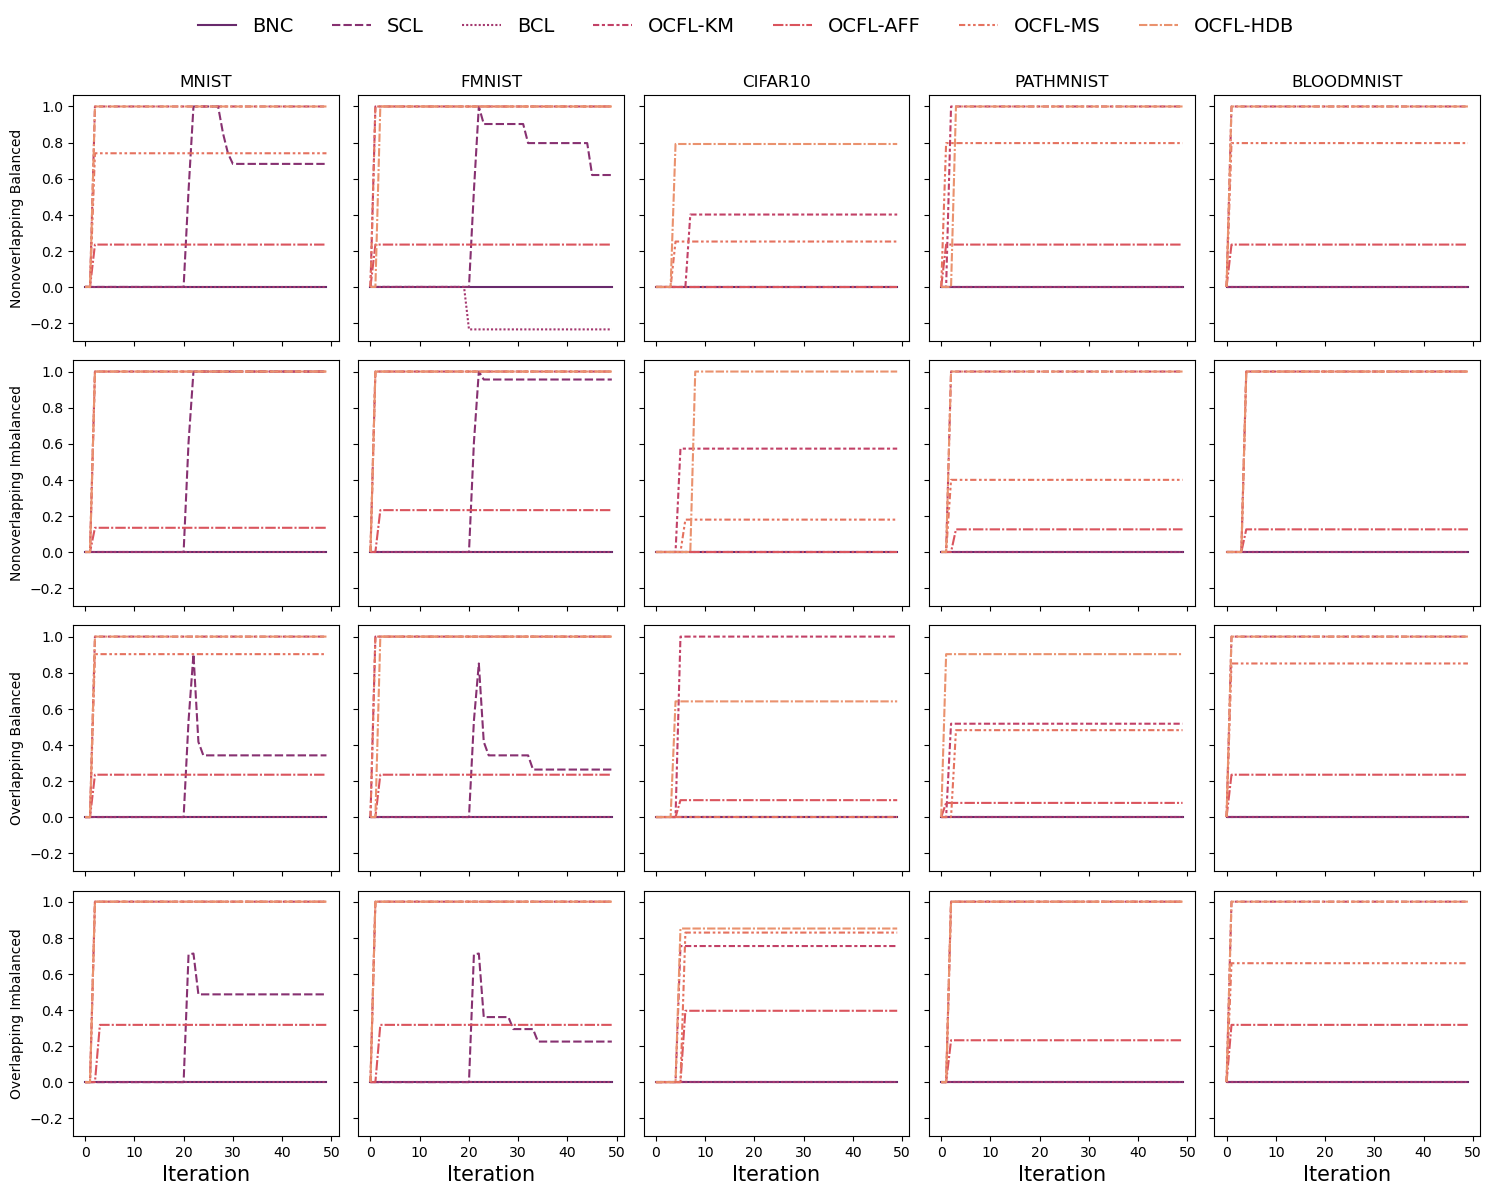

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12), sharex=True, sharey=True)
for col_pos, dataset in enumerate(datasets):
    row_pos = 0
    for split_type in split_types:
        for balance in split_balance:
            ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split_type}/{balance}/15')
            BASELINE_ATT = pd.read_csv(os.path.join(ROOT, f'baseline_{dataset}_{split_type}_{balance}_15/results/cluster_id_mapping.csv'))
            SATTLER_ATT = pd.read_csv(os.path.join(ROOT, f'sattler_{dataset}_{split_type}_{balance}_15/results/cluster_id_mapping.csv'))
            BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, f'briggs_{dataset}_{split_type}_{balance}_15/results/cluster_id_mapping.csv'))
            KMEANS_ATT = pd.read_csv(os.path.join(ROOT, f'kmeans_{dataset}_{split_type}_{balance}_15/results/cluster_id_mapping.csv'))
            AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, f'affinity_{dataset}_{split_type}_{balance}_15/results/cluster_id_mapping.csv'))
            MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, f'meanshift_{dataset}_{split_type}_{balance}_15/results/cluster_id_mapping.csv'))
            HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, f'HDBSCAN_{dataset}_{split_type}_{balance}_15/results/cluster_id_mapping.csv'))
            
            true_labels = TRUE_LABELS[f'{split_type}_{balance}_15']
            BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
            SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
            BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
            KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
            AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
            MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
            HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
        
            RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB'], index=range(50))
            RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-KM'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-AFF'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-MS'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-HDB'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            
            sns.lineplot(RAND_SCORES, ax=axes[row_pos, col_pos], palette='flare_r')
            axes[row_pos, col_pos].get_legend().remove()
            # Add name of the dataset on the top of the column
            if row_pos == 0:
                axes[row_pos, col_pos].set_title(dataset)
            row_pos += 1


# Adds types of splits
axes[0, 0].set_ylabel("Nonoverlapping Balanced")
axes[1, 0].set_ylabel("Nonoverlapping Imbalanced")
axes[2, 0].set_ylabel("Overlapping Balanced")
axes[3, 0].set_ylabel("Overlapping Imbalanced")

# Adds labeling of the x-axis
for i in range(5):
    axes[-1, i].set_xlabel('Iteration', fontsize=15)

# Collect handles and labels from all subplots
axes = axes.flatten()
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Deduplicate labels
unique = dict(zip(labels, handles))

# Add one global legend
fig.legend(unique.values(), unique.keys(), loc='upper center', ncol=len(unique), fontsize = 14, frameon=False)

fig.tight_layout(rect=[0, 0, 1, 0.95])

### 30 CLIENTS

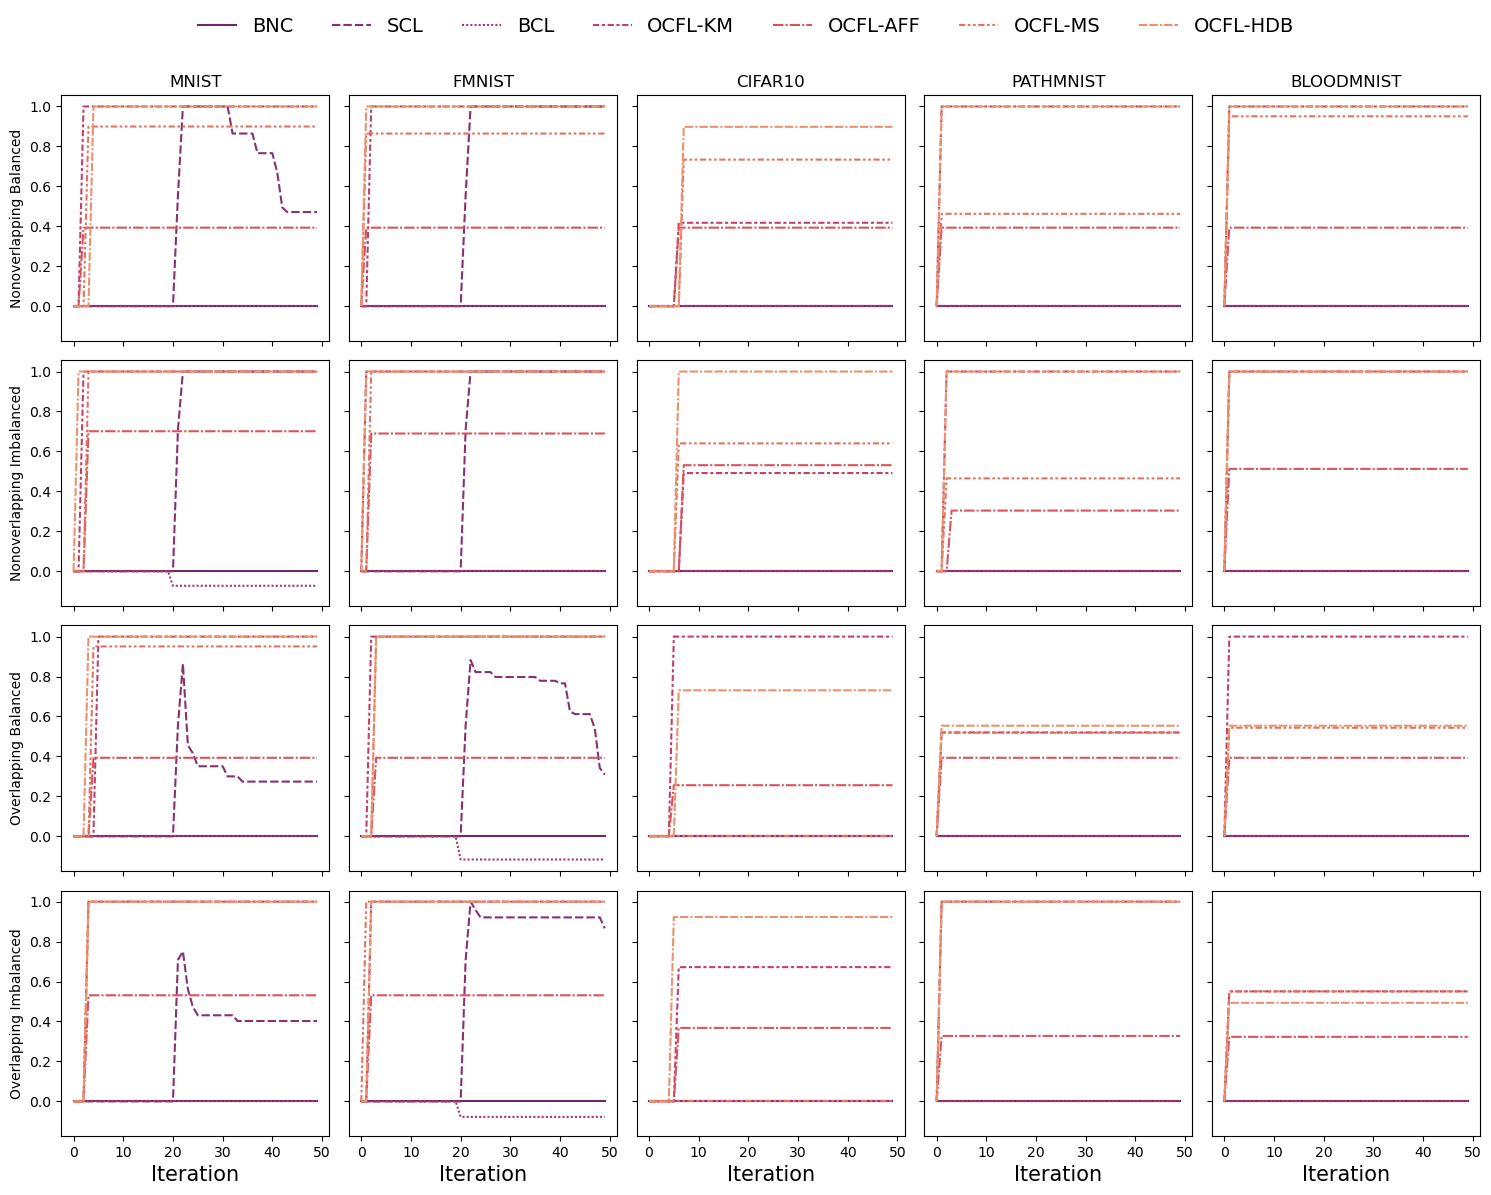

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12), sharex=True, sharey=True)
for col_pos, dataset in enumerate(datasets):
    row_pos = 0
    for split_type in split_types:
        for balance in split_balance:
            ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split_type}/{balance}/30')
            BASELINE_ATT = pd.read_csv(os.path.join(ROOT, f'baseline_{dataset}_{split_type}_{balance}_30/results/cluster_id_mapping.csv'))
            SATTLER_ATT = pd.read_csv(os.path.join(ROOT, f'sattler_{dataset}_{split_type}_{balance}_30/results/cluster_id_mapping.csv'))
            BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, f'briggs_{dataset}_{split_type}_{balance}_30/results/cluster_id_mapping.csv'))
            KMEANS_ATT = pd.read_csv(os.path.join(ROOT, f'kmeans_{dataset}_{split_type}_{balance}_30/results/cluster_id_mapping.csv'))
            AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, f'affinity_{dataset}_{split_type}_{balance}_30/results/cluster_id_mapping.csv'))
            MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, f'meanshift_{dataset}_{split_type}_{balance}_30/results/cluster_id_mapping.csv'))
            HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, f'HDBSCAN_{dataset}_{split_type}_{balance}_30/results/cluster_id_mapping.csv'))
            
            true_labels = TRUE_LABELS[f'{split_type}_{balance}_30']
            BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
            SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
            BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
            KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
            AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
            MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
            HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
        
            RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB'], index=range(50))
            RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-KM'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-AFF'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-MS'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            RAND_SCORES['OCFL-HDB'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
            
            sns.lineplot(RAND_SCORES, ax=axes[row_pos, col_pos], palette='flare_r')
            axes[row_pos, col_pos].get_legend().remove()
            # Add name of the dataset on the top of the column
            if row_pos == 0:
                axes[row_pos, col_pos].set_title(dataset)
            row_pos += 1


# Adds types of splits
axes[0, 0].set_ylabel("Nonoverlapping Balanced")
axes[1, 0].set_ylabel("Nonoverlapping Imbalanced")
axes[2, 0].set_ylabel("Overlapping Balanced")
axes[3, 0].set_ylabel("Overlapping Imbalanced")

# Adds labeling of the x-axis
for i in range(5):
    axes[-1, i].set_xlabel('Iteration', fontsize=15)

# Collect handles and labels from all subplots
axes = axes.flatten()
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Deduplicate labels
unique = dict(zip(labels, handles))

# Add one global legend
fig.legend(unique.values(), unique.keys(), loc='upper center', ncol=len(unique), fontsize = 14, frameon=False)

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Section IV: Last Clustering Round
Datasets: MNIST, FMNIST, CIFAR10, PATHMNIST, BLOODMNIST

In [12]:
SCENARIOS = ['MNIST15', 'MNIST30', 'FMNIST15', 'FMNIST30', 'CIFAR1015', 'CIFAR1030', 'PATHMNIST15', 'PATHMNIST30', 'BLOODMNIST15', 'BLOODMNIST30']
ALGOS = ['sattler', 'briggs', 'kmeans', 'affinity', 'meanshift', 'HDBSCAN']
SCENARIOS_ALGOS = [f"{scenario}_{algo}" for scenario in SCENARIOS for algo in ALGOS]
SPLITS = ['nonoverlaping_balanced', 'nonoverlaping_imbalanced', 'overlaping_balanced', 'overlaping_imbalanced']

clustering_round = pd.DataFrame(index=SCENARIOS_ALGOS, columns=SPLITS)

def detect_last_clustering_round(att_df: pd.DataFrame) -> int:
    """Return the (1-based) round number at which the last clustering was performed.
    Assumes each row = round snapshot. If the final row equals all previous rows, returns 1.
    """
    if att_df.empty:
        return None
    last_row = att_df.iloc[-1]
    diff_mask = (att_df != last_row).any(axis=1)  # rows that differ from final state
    if diff_mask.any():
        last_change_pos = diff_mask[diff_mask].index[-1]  # 0-based index of last differing row
        return last_change_pos + 2  # +1 to move to next row, +1 for 1-based round numbering
    return 1

for dataset in datasets:
    for split in split_types:
        for balance in split_balance:
            for no_clients in ['15', '30']:
                for algo in ALGOS:
                    ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                    path = os.path.join(ROOT, f'{algo}_{dataset}_{split}_{balance}_{no_clients}', 'results', 'cluster_id_mapping.csv')
                    QUERY_KEY_ROW = f"{dataset}{no_clients}_{algo}"
                    QUERY_KEY_COL = f"{split}_{balance}"
                    try:
                        ATT = pd.read_csv(path)
                    except FileNotFoundError:
                        clustering_round.loc[QUERY_KEY_ROW, QUERY_KEY_COL] = None
                        continue
                    clustering_round.loc[QUERY_KEY_ROW, QUERY_KEY_COL] = detect_last_clustering_round(ATT)

if not os.path.exists(os.path.join(os.getcwd(), 'tables', 'clustering_round')):
    os.makedirs(os.path.join(os.getcwd(), 'tables', 'clustering_round'))

with open(os.path.join(os.getcwd(), 'tables', 'clustering_round', 'last_clustering_round.tex'), 'w+') as file:
    file.write(clustering_round.to_latex())

In [13]:
clustering_round

,nonoverlaping_balanced,nonoverlaping_imbalanced,overlaping_balanced,overlaping_imbalanced
MNIST15_sattler,31,23,25,24
MNIST15_briggs,21,21,21,21
MNIST15_kmeans,3,3,3,3
MNIST15_affinity,3,3,3,4
MNIST15_meanshift,3,3,3,3
MNIST15_HDBSCAN,3,3,3,3
MNIST30_sattler,44,23,35,34
MNIST30_briggs,21,21,21,21
MNIST30_kmeans,3,3,6,4
MNIST30_affinity,3,4,5,4
